# HW5 - Rating prediction using Amazon's Reviews
    
In this exercise, you'll train a text classification on a **subset** of the the Amazon's Reviews dataset. 

The Amazon's Reviews dataset  contains product reviews and metadata from Amazon, including 142.8 million reviews spanning May 1996 - July 2014.


We will focus on the Home and Kitchen segment which contains ~550k reviews and can be downloaded here: http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Home_and_Kitchen_5.json.gz

You will predict the rating that was given to a product from the review.

The dataset contains the following fields for each review, in JSON format:
1. "reviewerID": "A11N155CW1UV02",
1. "asin": "B000H00VBQ",
1. "reviewerName": "AdrianaM"
1. "helpful": [0, 0]
1. "reviewText": "I had big expectations because I love English TV, in particular Investigative and detective stuff but this guy is really boring. It didn't appeal to me at all."
1. "overall": 2.0
1. "summary": "A little bit boring for me"
1. "unixReviewTime": 1399075200
1. "reviewTime": "05 3, 2014"




Please note that the **only** two fields that you are allowed to use in this exercise are "reviewText" which contains the review and "overall" which contains the rating. Other than that you have the **option** to use the "asin" field which is a unique product identifier. You may (or may not :) ) find this field useful.

In [71]:
!wget -nc http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Home_and_Kitchen_5.json.gz

File ‘reviews_Home_and_Kitchen_5.json.gz’ already there; not retrieving.



In [2]:
!wget -nc http://nlp.stanford.edu/data/glove.6B.zip

File ‘glove.6B.zip’ already there; not retrieving.



## General guidelines

1. You are required to implement at least two models.
1. The first should be a CNN or an RNN (or a combination) and should include the use of Glove embeddings.
1. The second model should be implemented using the transformers package and include Transfer learning concepts that were mentioned in the Lecture.
1. Pay attention to any preprocessing steps that are needed.
1. Feel free to be creative and use any method which was mentioned in the lectures (e.g., tf-idf, pos,...) extra points will be given to creativity.
1. The main criteria for evaluation is not the over-all score but rather the entire process (preprocessing, efficient training ...)





In [3]:
import pandas as pd
import numpy as np
import zipfile
import json
import gzip
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter
import nltk
import string
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
EMBED_DIM = 100
z = zipfile.ZipFile("glove.6B.zip")
glove_pd = pd.read_csv(z.open(f'glove.6B.{EMBED_DIM}d.txt'), sep=" ", quoting=3, header=None, index_col=0)
glove_pd.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,,,,,,,,,,,,,,,,,,,,,
the,-0.038194,-0.244870,0.72812,-0.399610,0.083172,0.043953,-0.391410,0.334400,-0.57545,0.087459,...,0.016215,-0.017099,-0.389840,0.87424,-0.72569,-0.51058,-0.520280,-0.14590,0.82780,0.270620
",",-0.107670,0.110530,0.59812,-0.543610,0.673960,0.106630,0.038867,0.354810,0.06351,-0.094189,...,0.349510,-0.722600,0.375490,0.44410,-0.99059,0.61214,-0.351110,-0.83155,0.45293,0.082577
.,-0.339790,0.209410,0.46348,-0.647920,-0.383770,0.038034,0.171270,0.159780,0.46619,-0.019169,...,-0.063351,-0.674120,-0.068895,0.53604,-0.87773,0.31802,-0.392420,-0.23394,0.47298,-0.028803
of,-0.152900,-0.242790,0.89837,0.169960,0.535160,0.487840,-0.588260,-0.179820,-1.35810,0.425410,...,0.187120,-0.018488,-0.267570,0.72700,-0.59363,-0.34839,-0.560940,-0.59100,1.00390,0.206640
to,-0.189700,0.050024,0.19084,-0.049184,-0.089737,0.210060,-0.549520,0.098377,-0.20135,0.342410,...,-0.131340,0.058617,-0.318690,-0.61419,-0.62393,-0.41548,-0.038175,-0.39804,0.47647,-0.159830


In [5]:
unk_df = pd.DataFrame([np.zeros(EMBED_DIM, dtype='float32'), np.random.uniform(-0.25, 0.25, EMBED_DIM)], index = ["", "UNK"], columns=glove_pd.columns)
pretrained_weights = pd.concat([unk_df, glove_pd])

In [6]:
pretrained_weights.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
UNK,0.222016,-0.088402,0.174565,0.094517,0.204757,-0.065316,-0.181016,-0.003887,-0.093449,0.208189,...,0.245414,0.178927,-0.104770,-0.041096,0.12125,0.035168,-0.202763,0.216884,-0.003667,0.060069
the,-0.038194,-0.244870,0.728120,-0.399610,0.083172,0.043953,-0.391410,0.334400,-0.575450,0.087459,...,0.016215,-0.017099,-0.389840,0.874240,-0.72569,-0.510580,-0.520280,-0.145900,0.827800,0.270620
",",-0.107670,0.110530,0.598120,-0.543610,0.673960,0.106630,0.038867,0.354810,0.063510,-0.094189,...,0.349510,-0.722600,0.375490,0.444100,-0.99059,0.612140,-0.351110,-0.831550,0.452930,0.082577
.,-0.339790,0.209410,0.463480,-0.647920,-0.383770,0.038034,0.171270,0.159780,0.466190,-0.019169,...,-0.063351,-0.674120,-0.068895,0.536040,-0.87773,0.318020,-0.392420,-0.233940,0.472980,-0.028803


In [7]:
del glove_pd
del unk_df

In [8]:
glove_index = {word: i for word, i in enumerate(pretrained_weights.index)}
# pretrained_weights = pretrained_weights.values

First we open the reviews file and turn it into a mappable object. The formatting of the text file has newline characters so we need to split the textfile on '\n' and ignore the last entry as the file ends with '\n' and therefore the last element in the list is empty.

In [9]:
with gzip.open('reviews_Home_and_Kitchen_5.json.gz', 'rt') as f:
    content = f.read()
content = content.split('\n')[:-1]
print(content[0])
print(content[-1])

{"reviewerID": "APYOBQE6M18AA", "asin": "0615391206", "reviewerName": "Martin Schwartz", "helpful": [0, 0], "reviewText": "My daughter wanted this book and the price on Amazon was the best.  She has already tried one recipe a day after receiving the book.  She seems happy with it.", "overall": 5.0, "summary": "Best Price", "unixReviewTime": 1382140800, "reviewTime": "10 19, 2013"}
{"reviewerID": "A3AHOSISKNBLZ6", "asin": "B00LBFUU12", "reviewerName": "Tonya S", "helpful": [0, 0], "reviewText": "My kids love these ice pop makers!!!  Since we have an abundance of orange juice at the moment, I poured some in each mold.  Within a couple hours, they were frozen.  I surprised the kids after they spent the afternoon swimming, and they were very excited about their orange juice pops.  The molds worked great.  I love that they have lids so they are individually self contained.  The kids liked that they weren't messy as they melted.  Now the kids are begging me to make pudding pops.  We'll be us

Now that we have a list of JSONifiable strings we can turn our reviews into a mapping where each review has a unique ID

In [10]:
reviews = pd.DataFrame.from_records([json.loads(r) for r in content])
del content

Taking a look at the fields, the "asin" field could be used to create an average rating per product feature, which could help further down the line to predict a specific rating. Let's do it

In [12]:
reviews['avg_product_rating'] = reviews.groupby('asin').overall.transform('mean')
reviews = reviews[['asin', 'reviewText', 'overall', 'avg_product_rating']]
reviews.head()

,asin,reviewText,overall,avg_product_rating
0,0615391206,My daughter wanted this book and the price on ...,5.0,4.454545
1,0615391206,I bought this zoku quick pop for my daughterr ...,5.0,4.454545
2,0615391206,There is no shortage of pop recipes available ...,4.0,4.454545
3,0615391206,This book is a must have if you get a Zoku (wh...,5.0,4.454545
4,0615391206,This cookbook is great. I have really enjoyed...,4.0,4.454545


Now we need to decide how to preprocess the review texts. First lets check a few stats about the reviews, like max/min length and punctuation count. Also, let's check the distribution of reviews by stars

In [13]:
punctuation = string.punctuation
tqdm.pandas()

In [14]:
reviews['review_len'] = reviews.reviewText.progress_apply(len)
reviews['punctuation_count'] = reviews.reviewText.progress_apply(lambda x: sum([1 for c in x if c in punctuation]))

100%|██████████| 551682/551682 [00:12<00:00, 42837.84it/s]


Mean review length: 524.0644320459975


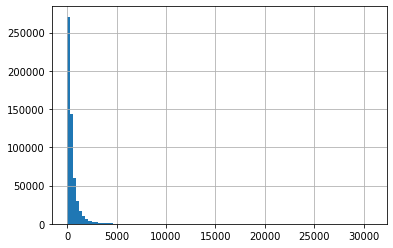

In [15]:
reviews.review_len.hist(bins=100)
print(f'Mean review length: {reviews.review_len.mean()}')
# plt.show()

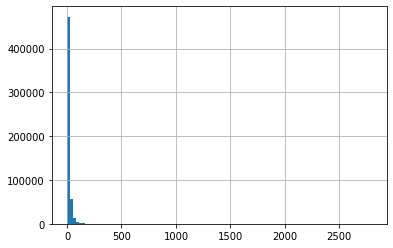

In [16]:
reviews.punctuation_count.hist(bins=100)

Seems like the distribution of review lenghts is pareto-like, so most reviews are relatively short

Next, we'll use the NLTK word_tokenize and tokenize each review, and check the distribution of number of tokens per review

In [17]:
reviews['tokenized_review'] = reviews.reviewText.progress_apply(word_tokenize)
reviews['token_count'] = reviews.tokenized_review.progress_apply(len)

100%|██████████| 551682/551682 [00:00<00:00, 1010912.02it/s]


In [18]:
reviews.head()

,asin,reviewText,overall,avg_product_rating,review_len,punctuation_count,tokenized_review,token_count
0,0615391206,My daughter wanted this book and the price on ...,5.0,4.454545,158,3,"[My, daughter, wanted, this, book, and, the, p...",33
1,0615391206,I bought this zoku quick pop for my daughterr ...,5.0,4.454545,125,2,"[I, bought, this, zoku, quick, pop, for, my, d...",28
2,0615391206,There is no shortage of pop recipes available ...,4.0,4.454545,2353,88,"[There, is, no, shortage, of, pop, recipes, av...",488
3,0615391206,This book is a must have if you get a Zoku (wh...,5.0,4.454545,334,9,"[This, book, is, a, must, have, if, you, get, ...",73
4,0615391206,This cookbook is great. I have really enjoyed...,4.0,4.454545,538,16,"[This, cookbook, is, great, ., I, have, really...",111


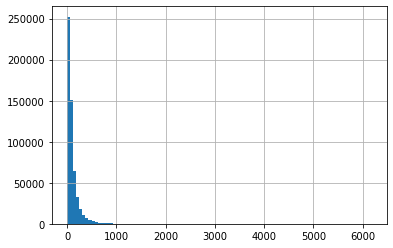

In [19]:
reviews.token_count.hist(bins=100)

In [20]:
print(f'Mean token count: {reviews.token_count.mean()}')
print(reviews.loc[reviews.token_count <= 200].token_count.size/reviews.token_count.size)

Mean token count: 111.34337897556927
0.8644273331375684


This distribution is naturally also pareto-like, which means that we can cap the maximum number of tokens we get embeddings for at a relatively low number without losing too much information. +86% of reviews are no longer than 200 tokens

In [21]:
token_counts = Counter()
_ = reviews.tokenized_review.progress_apply(lambda x: token_counts.update(x))

100%|██████████| 551682/551682 [00:08<00:00, 61972.36it/s]


We'll create embeddings from the tokenized reviews that are padded to a max length of 200 tokens. We'll do this in pure python since I don't want to extract embeddings until after the reviews are padded

In [22]:
MAX_LENGTH = 100
def pad_or_truncate(some_list, target_len):
    return some_list[:target_len] + ['']*(target_len - len(some_list))
reviews['tokenized_review_pad'] = reviews.tokenized_review.progress_apply(lambda x: pad_or_truncate(x, MAX_LENGTH))

100%|██████████| 551682/551682 [00:06<00:00, 79370.18it/s] 


In [23]:
print(len(token_counts))
vocab = ['', 'UNK'] + [t for t, v in token_counts.items() if v > 1]
print(len(vocab))
vocabidx = {word: i for i, word in enumerate(vocab)}
print(len(vocabidx))
vocabidx_df = pd.DataFrame.from_dict(vocabidx, orient='index')
vocabidx_df.head()
mean_vec = pretrained_weights.mean(axis=0)
embeddings = vocabidx_df.merge(pretrained_weights, how='left', left_index=True, right_index=True).set_index(0)
embeddings.fillna(mean_vec.to_dict(), axis=0, inplace=True)

508070
167290
167290


In [24]:
reviews['encoded_review'] = reviews.tokenized_review_pad.progress_apply(lambda x: [vocabidx.get(t, vocabidx['UNK']) for t in x])

100%|██████████| 551682/551682 [00:12<00:00, 43773.37it/s]


We have to make sure that the different ratings are represented equally, that we have a balanced dataset.

In [30]:
print(reviews.groupby('overall').size())

overall
1.0     27106
2.0     24313
3.0     45059
4.0    105508
5.0    349696
dtype: int64


Our smallest class has 24313 examples, so lets take 20000 examples of each class.

In [32]:
print(reviews.groupby('overall').size()/reviews.overall.size)
reviews_df = reviews.groupby('overall').apply(lambda x: x.sample(n=20000)).reset_index(drop = True)
print(reviews_df.groupby('overall').size()/reviews_df.overall.size)

overall
1.0    0.049133
2.0    0.044071
3.0    0.081676
4.0    0.191248
5.0    0.633872
dtype: float64
overall
1.0    0.2
2.0    0.2
3.0    0.2
4.0    0.2
5.0    0.2
dtype: float64


In [33]:
X = reviews_df[['encoded_review','avg_product_rating']].values
y = reviews_df['overall'].astype(float).tolist()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

In [34]:
class ReviewsDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx][0], dtype=torch.long)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        prior = torch.tensor(self.X[idx][1], dtype=torch.float32)
        return x, y, prior

In [35]:
train_data = ReviewsDataset(X_train, y_train)
val_data = ReviewsDataset(X_val, y_val)

In [36]:
batch_size = 5000
vocab_size = len(vocab)
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_data, batch_size=batch_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [37]:
def train_model(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            l = l.reshape(-1, 1)
#             x.to(device), y.to(device), l.to(device), model.to(device)
            y_pred = model(x, l)
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            torch.cuda.empty_cache()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_rmse = validation_metrics(model, val_dl)
        if i % 5 == 1:
            print("train loss %.3f, val loss %.3f, val accuracy %.3f, and val rmse %.3f" % (sum_loss/total, val_loss, val_acc, val_rmse))

def validation_metrics (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y, l in val_dl:
        l = l.reshape(-1, 1)
#         x.to(device), y.to(device), l.to(device), model.to(device)
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        torch.cuda.empty_cache()
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    return sum_loss/total, correct/total, sum_rmse/total

In [46]:
class LSTM_glove_vecs_with_avg(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, glove_weights, retrain_embeds=False) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.embeddings.weight.data.copy_(glove_weights)
        self.embeddings.weight.requires_grad = retrain_embeds ## freeze embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim+1, 6)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        out = torch.cat([ht[-1], l], dim=-1)
        return self.linear(out)
    
class LSTM_glove_vecs(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, glove_weights, retrain_embeds=False) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.embeddings.weight.data.copy_(glove_weights)
        self.embeddings.weight.requires_grad = retrain_embeds ## freeze embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 6)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [39]:
embeddings = torch.from_numpy(embeddings.values)
model1 = LSTM_glove_vecs_with_avg(vocab_size, EMBED_DIM, 10, embeddings)
model2 = LSTM_glove_vecs(vocab_size, EMBED_DIM, 10, embeddings)

In [40]:
print('Results with Average rating feature')
train_model(model1, epochs=30, lr=0.1)
train_model(model1, epochs=30, lr=0.05)

Results with Average rating feature
train loss 1.571, val loss 1.553, val accuracy 0.289, and val rmse 1.885
train loss 1.517, val loss 1.512, val accuracy 0.311, and val rmse 1.861
train loss 1.510, val loss 1.506, val accuracy 0.310, and val rmse 1.678
train loss 1.509, val loss 1.512, val accuracy 0.301, and val rmse 1.734
train loss 1.508, val loss 1.505, val accuracy 0.307, and val rmse 1.721
train loss 1.504, val loss 1.505, val accuracy 0.312, and val rmse 1.770
train loss 1.505, val loss 1.503, val accuracy 0.309, and val rmse 1.807
train loss 1.501, val loss 1.501, val accuracy 0.314, and val rmse 1.691
train loss 1.501, val loss 1.502, val accuracy 0.311, and val rmse 1.677
train loss 1.501, val loss 1.503, val accuracy 0.313, and val rmse 1.754
train loss 1.500, val loss 1.504, val accuracy 0.311, and val rmse 1.714
train loss 1.501, val loss 1.503, val accuracy 0.314, and val rmse 1.737


In [42]:
torch.save(model1.state_dict(), 'cross_entropy_lstm_with_avg.pth')

In [43]:
print('Results without Average rating feature')
train_model(model2, epochs=30, lr=0.1)
train_model(model2, epochs=30, lr=0.05)

Results without Average rating feature
train loss 1.598, val loss 1.603, val accuracy 0.234, and val rmse 1.896
train loss 1.592, val loss 1.601, val accuracy 0.239, and val rmse 2.066
train loss 1.589, val loss 1.599, val accuracy 0.238, and val rmse 1.780
train loss 1.588, val loss 1.600, val accuracy 0.235, and val rmse 1.737
train loss 1.588, val loss 1.597, val accuracy 0.238, and val rmse 1.882
train loss 1.586, val loss 1.596, val accuracy 0.241, and val rmse 2.148
train loss 1.586, val loss 1.597, val accuracy 0.241, and val rmse 1.901
train loss 1.585, val loss 1.597, val accuracy 0.242, and val rmse 1.852
train loss 1.585, val loss 1.597, val accuracy 0.240, and val rmse 1.859
train loss 1.583, val loss 1.594, val accuracy 0.242, and val rmse 1.829
train loss 1.580, val loss 1.594, val accuracy 0.242, and val rmse 2.084
train loss 1.580, val loss 1.594, val accuracy 0.240, and val rmse 1.792


In [44]:
torch.save(model2.state_dict(), 'cross_entropy_lstm_without_avg.pth')

It seems that including the average rating leads to better results, although 31% accuracy doesn't seem great

Let's see what happens if we allow the embeddings to retrain

In [47]:
model1 = LSTM_glove_vecs_with_avg(vocab_size, EMBED_DIM, 10, embeddings, retrain_embeds=True)
model2 = LSTM_glove_vecs(vocab_size, EMBED_DIM, 10, embeddings, retrain_embeds=True)

In [48]:
print('Results with Average rating feature and retraining embeddings')
train_model(model1, epochs=30, lr=0.1)
train_model(model1, epochs=30, lr=0.05)

Results with Average rating feature and retraining embeddings
train loss 1.595, val loss 1.597, val accuracy 0.245, and val rmse 1.761
train loss 1.456, val loss 1.556, val accuracy 0.282, and val rmse 1.537
train loss 1.414, val loss 1.549, val accuracy 0.299, and val rmse 1.551
train loss 1.396, val loss 1.541, val accuracy 0.305, and val rmse 1.548
train loss 1.387, val loss 1.541, val accuracy 0.312, and val rmse 1.540
train loss 1.379, val loss 1.548, val accuracy 0.308, and val rmse 1.485
train loss 1.372, val loss 1.549, val accuracy 0.311, and val rmse 1.521
train loss 1.358, val loss 1.555, val accuracy 0.321, and val rmse 1.610
train loss 1.349, val loss 1.556, val accuracy 0.316, and val rmse 1.501
train loss 1.334, val loss 1.553, val accuracy 0.324, and val rmse 1.503
train loss 1.321, val loss 1.553, val accuracy 0.320, and val rmse 1.534
train loss 1.312, val loss 1.553, val accuracy 0.332, and val rmse 1.583


In [49]:
torch.save(model1.state_dict(), 'cross_entropy_lstm_with_avg_retrained.pth')

Let's try a regression model using RMSE loss.

In [52]:
class LSTM_glove_vecs_regr(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, glove_weights, retrain_embeds=False) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.embeddings.weight.data.copy_(glove_weights)
        self.embeddings.weight.requires_grad = retrain_embeds
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim+1, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        out = torch.cat([ht[-1], l], dim=-1)
        return self.linear(out)

In [53]:
def train_model_regr(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            y = y.float()
            l = l.reshape(-1, 1)
            x.to(device), y.to(device), l.to(device), model.to(device)
            y_pred = model(x, l)
            optimizer.zero_grad()
            loss = F.mse_loss(y_pred, y.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss = validation_metrics_regr(model, val_dl)
        if i % 5 == 1:
            print("train mse %.3f val rmse %.3f" % (sum_loss/total, val_loss))

def validation_metrics_regr (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    for x, y, l in valid_dl:
        l = l.reshape(-1, 1)
        x.to(device), y.to(device), l.to(device), model.to(device)
        y = y.float()
        y_hat = model(x, l)
        loss = np.sqrt(F.mse_loss(y_hat, y.unsqueeze(-1)).item())
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
    return sum_loss/total

In [54]:
model = LSTM_glove_vecs_regr(vocab_size, EMBED_DIM, 10, embeddings, retrain_embeds=False)

In [56]:
train_model_regr(model, epochs=30, lr=0.05)

train mse 1.812 val rmse 1.337
train mse 1.675 val rmse 1.291
train mse 1.654 val rmse 1.285
train mse 1.647 val rmse 1.286
train mse 1.645 val rmse 1.284
train mse 1.640 val rmse 1.283


In [57]:
train_model_regr(model, epochs=30, lr=0.05)

train mse 1.651 val rmse 1.291
train mse 1.626 val rmse 1.274
train mse 1.615 val rmse 1.270
train mse 1.606 val rmse 1.266
train mse 1.594 val rmse 1.263
train mse 1.593 val rmse 1.262


In [58]:
torch.save(model.state_dict(), 'rmse_lstm.pth')

## Retraining BERT

In [59]:
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cpu'

In [60]:
MAX_LEN = 100
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [61]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.review_text = dataframe.reviewText
        self.targets = self.data.overall
        self.max_len = max_len

    def __len__(self):
        return len(self.review_text)

    def __getitem__(self, index):
        review_text = str(self.review_text[index])
        review_text = " ".join(review_text.split())
         
        inputs = self.tokenizer.encode_plus(
            review_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [62]:
review_df = reviews[['reviewText', 'overall']].copy()
train_size = 0.8
train_dataset=review_df.sample(frac=train_size,random_state=200).reset_index(drop=True)
test_dataset=review_df.drop(train_dataset.index).reset_index(drop=True)


print("FULL Dataset: {}".format(review_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (551682, 2)
TRAIN Dataset: (441346, 2)
TEST Dataset: (110336, 2)


In [63]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [64]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 6)
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.bert(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

BERTClass(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [66]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [67]:
from tqdm import tqdm

def train(epoch):
    model.train()
    epoch_step = 0
    for data in tqdm(training_loader):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)
#         print(targets.shape, targets)
        outputs = model(ids, mask, token_type_ids)
#         print(outputs.shape, outputs)
        optimizer.zero_grad()
        loss = F.cross_entropy(outputs, targets)

        if epoch_step%100==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_step+=1

In [ ]:
for epoch in range(EPOCHS):
    train(epoch)

  0%|          | 0/27585 [00:00<?, ?it/s]

Epoch: 0, Loss:  1.960149884223938


  0%|          | 100/27585 [02:53<13:09:08,  1.72s/it]

Epoch: 0, Loss:  1.1099274158477783


  1%|          | 200/27585 [05:45<14:14:33,  1.87s/it]

Epoch: 0, Loss:  0.9037293791770935


  1%|          | 300/27585 [08:35<13:01:50,  1.72s/it]

Epoch: 0, Loss:  1.054735541343689


  1%|▏         | 400/27585 [11:26<12:54:01,  1.71s/it]

Epoch: 0, Loss:  1.0493417978286743


  2%|▏         | 500/27585 [14:18<12:52:08,  1.71s/it]

Epoch: 0, Loss:  0.5738181471824646


  2%|▏         | 600/27585 [17:08<12:44:12,  1.70s/it]

Epoch: 0, Loss:  0.9956778883934021


  3%|▎         | 700/27585 [19:57<12:49:01,  1.72s/it]

Epoch: 0, Loss:  0.8902661800384521


  3%|▎         | 800/27585 [22:48<12:19:44,  1.66s/it]

Epoch: 0, Loss:  0.700101375579834


  3%|▎         | 900/27585 [25:39<12:51:17,  1.73s/it]

Epoch: 0, Loss:  0.7081091403961182


  4%|▎         | 1000/27585 [28:28<12:17:26,  1.66s/it]

Epoch: 0, Loss:  0.7836403250694275


  4%|▍         | 1100/27585 [31:18<12:26:41,  1.69s/it]

Epoch: 0, Loss:  0.6795803904533386


  4%|▍         | 1200/27585 [34:06<12:29:33,  1.70s/it]

Epoch: 0, Loss:  0.5748094320297241


  5%|▍         | 1300/27585 [36:58<12:25:27,  1.70s/it]

Epoch: 0, Loss:  0.43579238653182983


  5%|▌         | 1400/27585 [39:46<12:26:27,  1.71s/it]

Epoch: 0, Loss:  0.49727141857147217


  5%|▌         | 1500/27585 [42:34<12:06:27,  1.67s/it]

Epoch: 0, Loss:  0.6305131316184998


  6%|▌         | 1528/27585 [43:21<12:08:39,  1.68s/it]

In [69]:
def validation(epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(tqdm(testing_loader), 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:
for epoch in range(EPOCHS):
    fin_outputs, fin_targets = validation(epoch)


100%|██████████| 6896/6896 [52:18<00:00,  2.20it/s]


In [75]:
y = torch.tensor(fin_targets)
pred = torch.tensor(fin_outputs)
pred = torch.max(pred, 1)[1]
accuracy = metrics.accuracy_score(y, pred)
f1_score_micro = metrics.f1_score(y, pred, average='micro')
f1_score_macro = metrics.f1_score(y, pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.7319279292343387
F1 Score (Micro) = 0.7319279292343386
F1 Score (Macro) = 0.5094528230436968
